In [1]:
#!/bin/env python3
print("hello world")

hello world


In [269]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 

In [3]:
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import audioFeatureExtraction

In [4]:
import pysrt

In [364]:
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, SimpleRNN, Embedding, Flatten, \
                         Concatenate, LSTM, LeakyReLU, Dropout, BatchNormalization
from keras.metrics import sparse_categorical_accuracy
from keras.callbacks import EarlyStopping

In [6]:
import os
import csv
import re
import collections
import random
import json
from glob import glob as glob

In [7]:
import pickle

In [8]:
from progressbar import progressbar 

In [462]:
input_1 = Input(name='input', shape=(None, 21)) # variable frame timespan; fixed feature size
# bn_1 = BatchNormalization()(input_1)
# dense_1 = Dense(32, name='dense_1', activation='relu')(input_1)
rnn = LSTM(32, name='lstm_1', dropout=.1, recurrent_dropout=.1)(input_1)
# rnn = LSTM(28, name='lstm_2', activation='relu')(rnn)
dense_2 = Dense(25, name='dense_2', activation='relu')(rnn)
# act_1 = LeakyReLU(alpha=.1)(dense_1)
dense_3 = Dense(10, name='dense_3', activation='relu')(dense_2)
# act_2 = LeakyReLU(alpha=.1)(dense_2)
out = Dense(2, name='out', activation="softmax")(dense_3)

model = Model(inputs=[input_1,], outputs=[out,])
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()
# model.metrics_tensors += model.outputs
# if 'prediction' not in model.metrics_names: model.metrics_names += ['prediction']
model.metrics_names

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None, 21)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                6912      
_________________________________________________________________
dense_2 (Dense)              (None, 25)                825       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                260       
_________________________________________________________________
out (Dense)                  (None, 2)                 22        
Total params: 8,019
Trainable params: 8,019
Non-trainable params: 0
_________________________________________________________________


['loss', 'acc']

In [10]:
char_index_binary = {"chandler":0, "rachel":1, 0:"chandler", 1:"rachel"}
print(char_index_binary)

{0: 'chandler', 1: 'rachel', 'rachel': 1, 'chandler': 0}


In [11]:
basenames = sorted([s.split('/')[-1].split('.')[0] for s in glob("../data/*.mp4")])
print(basenames)
characters = set()
data_collection = []

for basename in progressbar(basenames[:], redirect_stdout=1):
    
    ep_data = pd.read_csv("../data/" + basename + "-faces.csv")

    info_dict = json.loads(open("../data/{basename}-dvt.jsonl".format(basename=basename), 'r').readline())

    chars_in_frame = collections.Counter(ep_data['frame'])

    ep_data['include'] = ep_data['score'] > .75
    ep_data['unique'] = ep_data['frame'].apply(lambda x: chars_in_frame[x]==1)

    sub_data = ep_data[['frame','character','score','include','unique']]
    sub_data = sub_data[sub_data['include'] & sub_data['unique']]

    framesdict = {}
    for row in sub_data.itertuples(index=True):
        framesdict[row.frame] = row

    framesdata = [(i[1].frame/info_dict['fps'], i[1]) for i in framesdict.items()]
    featurefiles = glob("../data/features/{basename}/*.f.pickle".format(basename=basename))

    intersect = {}

    def nearest_endpoint_cost_fn(file,frametime):
        endpoints = file.split('/')[-1].split('.')[0].split('_')
        start = [int(x) for x in endpoints[0].split('-')[:-1]]
        start = start[0]*60 + start[1]
        end = [int(x) for x in endpoints[1].split('-')[:-1]]
        end = end[0]*60 + end[1]
        return abs(min(frametime-start,end-frametime))

    for file in featurefiles[:]:
        endpoints = file.split('/')[-1].split('.')[0].split('_')
        start = [int(x) for x in endpoints[0].split('-')[:-1]]
        start = start[0]*60 + start[1]
        end = [int(x) for x in endpoints[1].split('-')[:-1]]
        end = end[0]*60 + end[1]
        nearestframe = min(framesdata, key=(lambda tup: abs(min(tup[0]-start,end-tup[0]))))
        intersect[file] = nearestframe[1].Index

    for frame in framesdata[:]:
        nearestclip = min(featurefiles,
                          key=(lambda f: nearest_endpoint_cost_fn(f,frame[0])))
        if (intersect.get(nearestclip,None) == frame[1].Index):
#             print(frame[0]/60, frame[1], nearestclip, nearest_endpoint_cost_fn(nearestclip,frame[0]), end='\n\n')
            with open(nearestclip, 'rb') as infile:
                featuredata = pickle.load(infile)
                data_collection.append([featuredata,frame[1].character])
                characters.add(frame[1].character)
#                 print(frame[1].character, frame[1].character in char_index_binary)
#                 training = model.train_on_batch([x[0]], [y[0]])
#                 if (1 % 10) == 0:
#                     print(training, char_index_binary[y[0]])

N/A% (0 of 24) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

['friends-s02-e01', 'friends-s02-e02', 'friends-s02-e03', 'friends-s02-e04', 'friends-s02-e05', 'friends-s02-e06', 'friends-s02-e07', 'friends-s02-e08', 'friends-s02-e09', 'friends-s02-e10', 'friends-s02-e11', 'friends-s02-e12', 'friends-s02-e13', 'friends-s02-e14', 'friends-s02-e15', 'friends-s02-e16', 'friends-s02-e17', 'friends-s02-e18', 'friends-s02-e19', 'friends-s02-e20', 'friends-s02-e21', 'friends-s02-e22', 'friends-s02-e23', 'friends-s02-e24']


100% (24 of 24) |########################| Elapsed Time: 0:01:21 Time:  0:01:21

In [90]:
collections.Counter([y for x,y in data_collection])

Counter({'chandler': 393, 'rachel': 345})

In [91]:
data_collection = [[x,y] for x,y in data_collection if y in char_index_binary]

In [92]:
print(len(data_collection), basenames, sep='\n')

738
['friends-s02-e01', 'friends-s02-e02', 'friends-s02-e03', 'friends-s02-e04', 'friends-s02-e05', 'friends-s02-e06', 'friends-s02-e07', 'friends-s02-e08', 'friends-s02-e09', 'friends-s02-e10', 'friends-s02-e11', 'friends-s02-e12', 'friends-s02-e13', 'friends-s02-e14', 'friends-s02-e15', 'friends-s02-e16', 'friends-s02-e17', 'friends-s02-e18', 'friends-s02-e19', 'friends-s02-e20', 'friends-s02-e21', 'friends-s02-e22', 'friends-s02-e23', 'friends-s02-e24']


In [93]:
index = 1
char_index = {}
for char in characters:
    char_index[char] = index
    char_index[index] = char
    index += 1
print("characters and their indices", char_index)

characters and their indices {'ross': 1, 2: 'monica', 3: 'rachel', 'monica': 2, 5: 'phoebe', 6: 'chandler', 1: 'ross', 'joey': 4, 'rachel': 3, 'phoebe': 5, 'chandler': 6, 4: 'joey'}


In [443]:
def train_generator(spl=None):
#     print(data_collection[0], len(data_collection[spl]), '\n')
    while True:
        random.shuffle(data_collection[spl])
        for x,y in data_collection[spl]:
            yield [x[0][:21].reshape(1,-1,21)], [char_index_binary[y]]

4490720


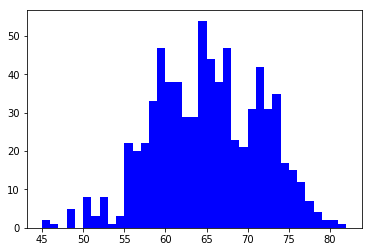

In [424]:
rep = np.array([data_collection[i][0][0][:21].mean() for i in range(len(data_collection))]) * -2**5
plt.hist(rep, bins=range(int(min(rep)), int(max(rep))+1, 1), color='blue', )
print(sum([len(data_collection[i][0][0]) for i in range(len(data_collection))]))

In [463]:
H = model.fit_generator(train_generator(spl=slice(0,int(.6*len(data_collection)))), epochs=32*8, steps_per_epoch=1024)
#                         callbacks = [EarlyStopping(monitor='loss', min_delta=0.001, patience=16,
#                                                    verbose=1, mode='auto')])
#                         validation_data=train_generator(spl=slice(int(.7*len(data_collection)),
#                                                                   int(1.*len(data_collection)))), validation_steps=100)

Epoch 1/256
1024/1024 [==============================] - 27s 26ms/step - loss: 0.6973 - acc: 0.5039
Epoch 2/256
1024/1024 [==============================] - 9s 8ms/step - loss: 0.6935 - acc: 0.5176
Epoch 3/256
1024/1024 [==============================] - 9s 8ms/step - loss: 0.6923 - acc: 0.5195
Epoch 4/256
1024/1024 [==============================] - 9s 8ms/step - loss: 0.6931 - acc: 0.5195
Epoch 5/256
1024/1024 [==============================] - 9s 8ms/step - loss: 0.6908 - acc: 0.5312
Epoch 6/256
1024/1024 [==============================] - 9s 8ms/step - loss: 0.6871 - acc: 0.5488
Epoch 7/256
1024/1024 [==============================] - 9s 8ms/step - loss: 0.6862 - acc: 0.5410
Epoch 8/256
1024/1024 [==============================] - 9s 8ms/step - loss: 0.6845 - acc: 0.5439
Epoch 9/256
1024/1024 [==============================] - 9s 8ms/step - loss: 0.6845 - acc: 0.5449
Epoch 10/256
1024/1024 [==============================] - 9s 8ms/step - loss: 0.6849 - acc: 0.5469
Epoch 11/256
1024

1024/1024 [==============================] - 9s 8ms/step - loss: 0.5952 - acc: 0.6338
Epoch 84/256
1024/1024 [==============================] - 9s 8ms/step - loss: 0.5976 - acc: 0.6533
Epoch 85/256
1024/1024 [==============================] - 9s 8ms/step - loss: 0.6008 - acc: 0.6348
Epoch 86/256
1024/1024 [==============================] - 9s 8ms/step - loss: 0.5854 - acc: 0.6699
Epoch 87/256
1024/1024 [==============================] - 9s 8ms/step - loss: 0.5955 - acc: 0.6494
Epoch 88/256
1024/1024 [==============================] - 9s 8ms/step - loss: 0.5961 - acc: 0.6455
Epoch 89/256
1024/1024 [==============================] - 9s 8ms/step - loss: 0.5880 - acc: 0.6709
Epoch 90/256
1024/1024 [==============================] - 9s 8ms/step - loss: 0.5959 - acc: 0.6475
Epoch 91/256
1024/1024 [==============================] - 9s 8ms/step - loss: 0.5861 - acc: 0.6660
Epoch 92/256
1024/1024 [==============================] - 9s 8ms/step - loss: 0.5790 - acc: 0.6670
Epoch 93/256
1024/1024 

1024/1024 [==============================] - 9s 8ms/step - loss: 0.5215 - acc: 0.7305
Epoch 166/256
1024/1024 [==============================] - 9s 8ms/step - loss: 0.5403 - acc: 0.7109
Epoch 167/256
1024/1024 [==============================] - 9s 8ms/step - loss: 0.5286 - acc: 0.7246
Epoch 168/256
1024/1024 [==============================] - 9s 8ms/step - loss: 0.5137 - acc: 0.7363
Epoch 169/256
1024/1024 [==============================] - 9s 8ms/step - loss: 0.5148 - acc: 0.7393
Epoch 170/256
1024/1024 [==============================] - 9s 8ms/step - loss: 0.5254 - acc: 0.7197
Epoch 171/256
1024/1024 [==============================] - 9s 8ms/step - loss: 0.5118 - acc: 0.7266
Epoch 172/256
1024/1024 [==============================] - 9s 8ms/step - loss: 0.5100 - acc: 0.7373
Epoch 173/256
1024/1024 [==============================] - 9s 8ms/step - loss: 0.5254 - acc: 0.7295
Epoch 174/256
1024/1024 [==============================] - 9s 8ms/step - loss: 0.5130 - acc: 0.7334
Epoch 175/256


1024/1024 [==============================] - 9s 8ms/step - loss: 0.4826 - acc: 0.7412
Epoch 248/256
1024/1024 [==============================] - 9s 8ms/step - loss: 0.4849 - acc: 0.7510
Epoch 249/256
1024/1024 [==============================] - 9s 8ms/step - loss: 0.4956 - acc: 0.7363
Epoch 250/256
1024/1024 [==============================] - 9s 8ms/step - loss: 0.4702 - acc: 0.7734
Epoch 251/256
1024/1024 [==============================] - 9s 8ms/step - loss: 0.4557 - acc: 0.7549
Epoch 252/256
1024/1024 [==============================] - 9s 8ms/step - loss: 0.5005 - acc: 0.7471
Epoch 253/256
1024/1024 [==============================] - 9s 8ms/step - loss: 0.4837 - acc: 0.7412
Epoch 254/256
1024/1024 [==============================] - 9s 8ms/step - loss: 0.4629 - acc: 0.7715
Epoch 255/256
1024/1024 [==============================] - 9s 8ms/step - loss: 0.5147 - acc: 0.7295
Epoch 256/256
1024/1024 [==============================] - 9s 8ms/step - loss: 0.4794 - acc: 0.7715


In [464]:
# seen data
seen = model.evaluate_generator(train_generator(spl=slice(None,int(.6*len(data_collection)),None)),steps=int(.4*len(data_collection)))
# unseen data
unseen = model.evaluate_generator(train_generator(spl=slice(int(.6*len(data_collection)),None, None)),steps=int(.4*len(data_collection)))
print('seen', seen, 'unseen', unseen, sep='\n')

seen
[0.38309585450242273, 0.8101694915254237]
unseen
[1.3434228509499793, 0.559322033898305]


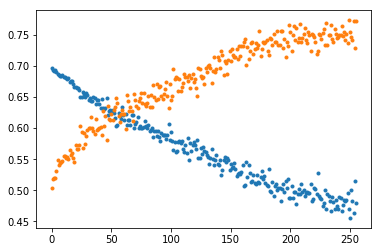

In [484]:
plt.plot(range(len(H.history['loss'])), H.history['loss'], '.', H.history['acc'], '.')

In [451]:
lim2 = slice(int(0.6*len(data_collection)),int(.9*len(data_collection)))
y_hat = [char_index_binary[np.argmax(model.predict_on_batch(x=[x[0][:21].reshape(1,-1,21)]))]
         for x,y in data_collection[lim2]]
y_actual = [y for x,y in data_collection[lim2]]

In [452]:
pd.crosstab(pd.Series(y_hat), pd.Series(y_actual))

col_0     chandler  rachel
row_0                     
chandler        73      67
rachel          39      43

In [453]:
hat = collections.Counter(y_hat)
act = collections.Counter(y_actual)
print('y_hat', hat)
print('rachel hat %:', hat['rachel']/sum(hat.values()))
print('chandler hat %:', hat['chandler']/sum(hat.values()))
print()
print('y', act)
print('rachel act %:', act['rachel']/sum(act.values()))
print('chandler act %:', act['chandler']/sum(act.values()))

y_hat Counter({'chandler': 140, 'rachel': 82})
rachel hat %: 0.36936936936936937
chandler hat %: 0.6306306306306306

y Counter({'chandler': 112, 'rachel': 110})
rachel act %: 0.4954954954954955
chandler act %: 0.5045045045045045


In [133]:
# r = 128
# lim = slice(0, int(.5*len(data_collection)))
# it = 0
# # acc_calc = [[],[]] # y, y_hat
# for p in range(r):#,redirect_stdout=True):
#     print("\t%.1f"%(p*100/r),"percent done", '\t\t\t\n', end='\r')
#     for x,y in data_collection[lim]:
# #         print(x[0].reshape(1,1,-1,34),y)
#         training = model.train_on_batch([x[0].reshape(1,-1,34)], [char_index_binary[y]])
#         print(training, end='\r')
#         it += 1

	0.0 percent done 			
	0.8 percent done 			y([[0.44115004, 0.55884993]], dtype=float32)]]]
	1.6 percent done 			ay([[0.50248337, 0.49751666]], dtype=float32)]]
	2.3 percent done 			y([[0.4339791 , 0.56602085]], dtype=float32)]]]
	3.1 percent done 			y([[0.25733414, 0.7426658 ]], dtype=float32)]]]
	3.9 percent done 			ay([[0.47232598, 0.527674  ]], dtype=float32)]]
	4.7 percent done 			y([[0.49799135, 0.5020087 ]], dtype=float32)]]]]
	5.5 percent done 			ay([[0.44460925, 0.5553907 ]], dtype=float32)]]
	6.2 percent done 			ay([[0.37675768, 0.62324226]], dtype=float32)]]
	7.0 percent done 			y([[0.40935433, 0.59064573]], dtype=float32)]]]
	7.8 percent done 			y([[0.5043081 , 0.49569187]], dtype=float32)]]]
	8.6 percent done 			y([[0.38049275, 0.61950725]], dtype=float32)]]]
	9.4 percent done 			ay([[0.38204107, 0.617959  ]], dtype=float32)]]
	10.2 percent done 			y([[0.35171777, 0.6482823 ]], dtype=float32)]]
	10.9 percent done 			y([[0.46865097, 0.531349  ]], dtype=float32)]]
	11.7 perce

	93.8 percent done 			y([[0.02962446, 0.9703755 ]], dtype=float32)]]]t32)]
	94.5 percent done 			y([[0.03999177, 0.96000826]], dtype=float32)]]]
	95.3 percent done 			y([[0.11786735, 0.88213265]], dtype=float32)]]]
	96.1 percent done 			y([[0.03202881, 0.9679712 ]], dtype=float32)]]]
	96.9 percent done 			ay([[0.02936121, 0.9706388 ]], dtype=float32)]]
	97.7 percent done 			([[0.14269093, 0.85730904]], dtype=float32)]]]]
	98.4 percent done 			ay([[0.03368413, 0.9663158 ]], dtype=float32)]]
	99.2 percent done 			y([[0.00864727, 0.99135274]], dtype=float32)]]]


In [178]:
for index in range(lim2.start,lim2.stop):
    y, y_hat = data_collection[index][1], np.argmax(model.predict_on_batch(x=[data_collection[index][0][0].reshape(1,-1,34),]))
    max_pred = np.max(model.predict_on_batch(x=[data_collection[index][0][0].reshape(1,-1,34),]))
    print("{0:d} {1:d} {2:f}".format(char_index_binary[y], y_hat, max_pred))

1 0 0.779007
1 1 0.809747
1 0 0.998644
0 0 0.981997
1 0 0.902373
1 0 0.978031
1 0 0.970444
1 0 0.980899
0 0 0.998710
0 0 0.975225
1 0 0.967023
0 0 0.982678
1 0 0.974343
1 1 0.859899
0 0 0.979861
1 0 0.980683
1 0 0.976277
1 1 0.840193
0 0 0.981871
0 0 0.981997
0 0 0.980567
1 1 0.749041
0 0 0.998732
0 0 0.982712
0 0 0.976248
0 1 0.509825
1 1 0.746162
0 0 0.981608
1 0 0.550970
1 1 0.822403
0 0 0.998120
0 0 0.975225
1 0 0.982503
0 1 0.597813
0 0 0.927511
0 0 0.979111
1 0 0.981836
0 0 0.981252
0 0 0.982885
0 0 0.974386
0 0 0.951897
0 0 0.974178
1 1 0.811022
1 0 0.986942
1 0 0.979116
0 0 0.955909
1 0 0.982712
1 1 0.846451
0 0 0.949059
1 0 0.951481
1 0 0.977666
0 0 0.979740
0 0 0.985282
1 0 0.977719
0 0 0.985282
1 0 0.982737
1 0 0.974337
0 0 0.985183
0 0 0.752240
0 0 0.980903
0 0 0.980177
0 0 0.985538
0 0 0.948191
1 0 0.974343
0 0 0.948191
0 0 0.982249
0 0 0.983251
1 0 0.978960
1 0 0.976446
1 0 0.979086
1 0 0.974380
0 0 0.965308
1 0 0.981520
1 0 0.977825
0 0 0.981858
0 0 0.979784
0 0 0.977613

In [ ]:
ls = os.listdir("./data/friends-s02-e03/ogg/")
print("no. of files: %d"%(len(ls)))
subs = pysrt.open("./data/annot-friends-s02-e03.srt")
print("no. of subtitle entries: %d"%(len(subs)))
data = list()
characters = set()
X1 = []
X2 = []
Y = []
for filename,sub in zip(ls,subs):
    [Fs, x] = audioBasicIO.readAudioFile("./data/friends-s02-e03/ogg/%s"%(filename,))
    lchannel, f_names = audioFeatureExtraction.stFeatureExtraction(x[:,0], Fs, 0.050*Fs, 0.025*Fs)
    rchannel, f_names = audioFeatureExtraction.stFeatureExtraction(x[:,1], Fs, 0.050*Fs, 0.025*Fs)
    data.append(np.array([
            lchannel[:,:], rchannel[:,:], re.sub('<[^<]+?>', '', sub.text.lower()).split()[0], sub.text.split()[-1]
        ]))
    X1.append(np.array([lchannel[:,:], rchannel[:,:]]).reshape(1,-1,34))
    X2.append(np.array([ord(c) for c in sub.text.lower().split()[0]]).reshape(1,-1,1))
    Y.append(sub.text.split()[-1])
    characters.add(Y[-1])
characters = sorted(characters)
print("len data: %s" % len(data))
print("len data[0]: %s" % len(data[0]))

In [ ]:
with open('data_and_labels.pickle', 'wb') as out:
    pickle.dump([X1,Y,characters], file=out)

In [7]:
with open('data_and_labels.pickle', 'rb') as infile:
    X1,Y,characters = pickle.load(infile)
    characters = sorted(characters)

In [8]:
char_index = dict()
index = 1
for char in characters:
    if '<' in char: continue
    char_index[char] = index
    char_index[index] = char
    index += 1
print("Characters and their indices", char_index)

Characters and their indices {'title': 13, 1: 'Xallison', 'Xattorney': 2, 3: 'chandler', 4: 'heckles', 5: 'janice', 6: 'joey', 7: 'mix', 8: 'monica', 9: 'na', 10: 'phoebe', 11: 'rachel', 12: 'ross', 2: 'Xattorney', 14: 'treeger', 'rachel': 11, 'janice': 5, 'joey': 6, 'chandler': 3, 'mix': 7, 'ross': 12, 'na': 9, 'phoebe': 10, 'Xallison': 1, 13: 'title', 'monica': 8, 'treeger': 14, 'heckles': 4}


In [10]:
len(X1),len(Y),char_index[Y[0]], X1[index].shape

(530, 530, 3, (1, 126, 34))

In [43]:
[char_index['ross']]

[12]

In [85]:
char_index_binary = {"ross":0, "rachel":1, 0:"ross", 1:"rachel"}
print(char_index_binary)

{0: 'ross', 1: 'rachel', 'ross': 0, 'rachel': 1}


In [176]:
pooled_data = []
for index in range(int(len(X1))):
        if Y[index] in char_index_binary:
            pooled_data.append(([X1[index],], [char_index_binary[Y[index]]]))
random.shuffle(pooled_data)

In [177]:
r = 256
lim = slice(0, int(.5*len(pooled_data)))
for p in range(r):#,redirect_stdout=True):
    print("\t\t%.2f"%(p*100/r),"percent done")
    for x,y in pooled_data[lim]:
        training = model.train_on_batch([x[0]], [y[0]])
        if (1 % 10) == 0:
            print(training, char_index_binary[y[0]])

		0.00 percent done
		0.39 percent done
		0.78 percent done
		1.17 percent done
		1.56 percent done
		1.95 percent done
		2.34 percent done
		2.73 percent done
		3.12 percent done
		3.52 percent done
		3.91 percent done
		4.30 percent done
		4.69 percent done
		5.08 percent done
		5.47 percent done
		5.86 percent done
		6.25 percent done
		6.64 percent done
		7.03 percent done
		7.42 percent done
		7.81 percent done
		8.20 percent done
		8.59 percent done
		8.98 percent done
		9.38 percent done
		9.77 percent done
		10.16 percent done
		10.55 percent done
		10.94 percent done
		11.33 percent done
		11.72 percent done
		12.11 percent done
		12.50 percent done
		12.89 percent done
		13.28 percent done
		13.67 percent done
		14.06 percent done
		14.45 percent done
		14.84 percent done
		15.23 percent done
		15.62 percent done
		16.02 percent done
		16.41 percent done
		16.80 percent done
		17.19 percent done
		17.58 percent done
		17.97 percent done
		18.36 percent done
		18.75 percent do

In [116]:
for index in range(int(.9*len(X1)),len(X1)):
    y_hat = np.argmax(model.predict_on_batch(x=[X1[index],]))
    max_pred = np.max(model.predict_on_batch(x=[X1[index],]))
    print("{0:d}  {1:f}".format(y_hat, max_pred))

1  0.735420
0  0.801831
1  0.696849
0  0.796231
0  0.776648
1  0.747136
0  0.799048
1  0.722643
1  0.652673
1  0.731219
1  0.656811
1  0.713111
1  0.735634
1  0.731744
1  0.700099
1  0.747175
1  0.733241
1  0.754784
1  0.745030
1  0.695073
1  0.744723
1  0.706122
1  0.706584
1  0.728146
0  0.801457
1  0.741564
1  0.712620
1  0.548273
0  0.802474
1  0.665104
0  0.561636
1  0.711773
1  0.697481
0  0.778056
1  0.725655
1  0.736663
0  0.545068
1  0.738869
0  0.796834
1  0.744084
1  0.717481
0  0.644662
1  0.738577
1  0.719702
1  0.732389
1  0.734520
1  0.732606
1  0.748748
0  0.643611
1  0.691709
0  0.537037
0  0.765036
1  0.737891


In [88]:
collections.Counter([char_index.get(y,None) for y in Y])

Counter({1: 3,
         10: 85,
         11: 57,
         12: 58,
         13: 12,
         14: 11,
         2: 11,
         3: 125,
         4: 6,
         5: 13,
         6: 56,
         7: 13,
         8: 68,
         9: 11,
         None: 1})

In [178]:
lim = slice(int(0.5*len(pooled_data)),int(1.*len(pooled_data)))
y_hat = [char_index_binary[np.argmax(model.predict_on_batch(x=[x[0]]))] for x,y in pooled_data[lim]]
y_actual = [char_index_binary[y[0]] for x,y in pooled_data[lim]]

In [179]:
pd.crosstab(pd.Series(y_hat), pd.Series(y_actual))
# col_0 	rachel 	ross
# row_0 		
# rachel 	57 	44
# ross 	0 	14

col_0   rachel  ross
row_0               
rachel      16    23
ross        12     7

In [180]:
collections.Counter(y_hat)

Counter({'rachel': 39, 'ross': 19})

In [181]:
collections.Counter(y_actual)

Counter({'rachel': 28, 'ross': 30})